[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github.com/Hanifan12/Food-Calories/blob/main/Food_Recognition.ipynb)

# Access Dataset
tensorflow-dataset food101

In [1]:
pip install tensorflow-datasets

In [2]:
## import library
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import os.path
from os import path

In [3]:
food101_builder = tfds.builder("food101")
food101_info = food101_builder.info

In [4]:
food101_builder.download_and_prepare(
    # download_dir = 'drive/MyDrive/Capstone/Dataset/Food101',
    download_config=None)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteSR9TGB/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteSR9TGB/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [5]:
datasets = food101_builder.as_dataset(
    split=None,
    batch_size=None,
    shuffle_files=False,
    read_config=None,
    as_supervised=True)

train_dataset, val_dataset = datasets["train"], datasets["validation"]
assert isinstance(train_dataset, tf.data.Dataset)

In [6]:
## print dataset type
ds_train = train_dataset
print(ds_train)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [7]:
## print the metadata
ds_info = food101_info
print(ds_info)

tfds.core.DatasetInfo(
    name='food101',
    version=2.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 75750,
        'validation': 25250,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      

In [8]:
num_classes = 101

# Pre-Processing

In [9]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # Resize the image
    image = tf.image.resize(image, (224, 224))   # 224 is default
    label = tf.expand_dims(label,axis=-1)
    label = tf.cast(label, tf.int32)
    return image, label

In [10]:
## normalize train dataset
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
## normalize validation dataset
ds_val = val_dataset
ds_val = ds_val.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(128, drop_remainder=True)
# ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
## check datatype after normalization
print(ds_train)
print(ds_val)

<PrefetchDataset shapes: ((128, 224, 224, 3), (128, 1)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((128, 224, 224, 3), (128, 1)), types: (tf.float32, tf.int32)>


# Visualization data

In [13]:
ds, info = tfds.load(name='food101', 
                     split='train', 
                     # data_dir = 'drive/MyDrive/Capstone/Dataset',
                     download=False,
                     with_info=True)

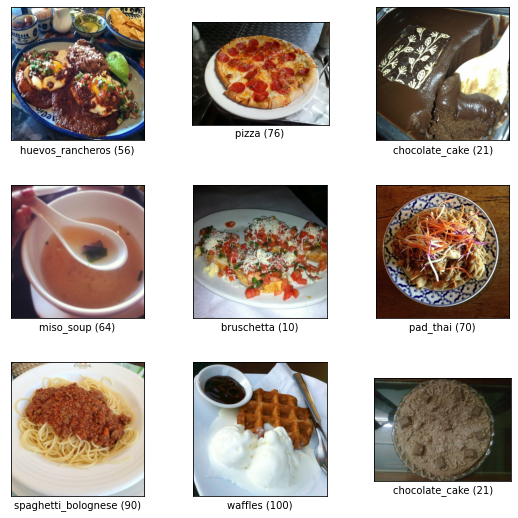

In [14]:
## show some examples images
fig = tfds.show_examples(ds, info)

# Train Model
Using trf learning

In [17]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
def build_model_mobile():
       # constructing the model
    base_model = keras.applications.mobilenet.MobileNet(weights="imagenet", 
                                                   include_top=False, 
                                                   input_shape=(224, 224, 3),
                                                   pooling='avg')
    for layer in base_model.layers:
        layer.trainable = False

    base_model.summary()

    # Adding custom Layers
    x = base_model.output
    x = Dense(128, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    predictions = Dense(101, activation="softmax")(x)

    # creating the final model
    model_final = Model(inputs=base_model.input, outputs=predictions)
    
    return model_final

model = build_model_mobile()
model.compile(loss=sparse_categorical_crossentropy, optimizer='adam', metrics=['acc'])

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 3,389,605
Trainable params: 160,741
Non-trainable params: 3,228,864
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(ds_train, epochs=2, validation_data=ds_val, verbose=1)

Epoch 1/2
591/591 [==============================] - 3581s 6s/step - loss: 3.2638 - accuracy: 0.2456 - val_loss: 1.8228 - val_accuracy: 0.5160
Epoch 2/2
591/591 [==============================] - 3649s 6s/step - loss: 1.9332 - accuracy: 0.5064 - val_loss: 1.6487 - val_accuracy: 0.5591


# Prediction

In [20]:
## make dictionary for label
label_path = '/root/tensorflow_datasets/food101/2.0.0/label.labels.txt'
dict_label = {}
i = 0

with open(label_path) as f:
    for line in f:
      dict_label[int(i)] = line.strip('\n')
      i += 1

print(dict_label)

{0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'beef_carpaccio', 4: 'beef_tartare', 5: 'beet_salad', 6: 'beignets', 7: 'bibimbap', 8: 'bread_pudding', 9: 'breakfast_burrito', 10: 'bruschetta', 11: 'caesar_salad', 12: 'cannoli', 13: 'caprese_salad', 14: 'carrot_cake', 15: 'ceviche', 16: 'cheesecake', 17: 'cheese_plate', 18: 'chicken_curry', 19: 'chicken_quesadilla', 20: 'chicken_wings', 21: 'chocolate_cake', 22: 'chocolate_mousse', 23: 'churros', 24: 'clam_chowder', 25: 'club_sandwich', 26: 'crab_cakes', 27: 'creme_brulee', 28: 'croque_madame', 29: 'cup_cakes', 30: 'deviled_eggs', 31: 'donuts', 32: 'dumplings', 33: 'edamame', 34: 'eggs_benedict', 35: 'escargots', 36: 'falafel', 37: 'filet_mignon', 38: 'fish_and_chips', 39: 'foie_gras', 40: 'french_fries', 41: 'french_onion_soup', 42: 'french_toast', 43: 'fried_calamari', 44: 'fried_rice', 45: 'frozen_yogurt', 46: 'garlic_bread', 47: 'gnocchi', 48: 'greek_salad', 49: 'grilled_cheese_sandwich', 50: 'grilled_salmon', 51: 'guacamole

In [21]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  img = fn
img_path = '/content/' + img

Saving spagheti-966389_1920.jpg to spagheti-966389_1920.jpg


In [ ]:
img = keras.preprocessing.image.load_img(
    img_path, target_size=(224, 224)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

This image most likely belongs to creme_brulee with a 1.18 percent confidence.


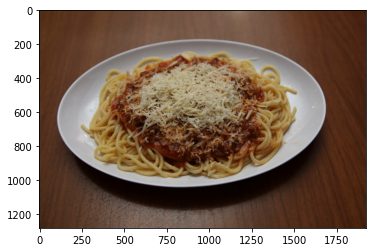

In [23]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(dict_label[np.argmax(score)], 100 * np.max(score))
)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.show()